## Libs Imports

In [1]:
from os.path import dirname, join, abspath
from os import getcwd
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import networkx as nx
import datetime
import json
import sys


sys.path.append('..')
from src.d01_cleandata.DataFilter import flatList

font = {'family' :'serif',
        'size'   : 14}

mp.rc('font', **font)
mp.rc('xtick', labelsize='small')
mp.rc('ytick', labelsize='small')

ROOT_FOLDER_PATH = dirname(getcwd())
DATA_PATH = join(ROOT_FOLDER_PATH, 'data')
SAVE_PATH = join(ROOT_FOLDER_PATH, 'sampleImages')

## Scrapped IG users

In [2]:
igUsers = ['luizaquental', 'gretathunberg', 'morganfreeman', 'neymarjr']
igUser = igUsers[3]

## Entry of Json data of users and date formatting

In [3]:
with open(join(DATA_PATH, igUser + '-cleanned.json')) as f:
    dataJson = json.load(f)

dataDict = pd.DataFrame.from_dict(dataJson).transpose()
dataDict['date'] = pd.to_datetime(dataDict['date'], format='%Y-%m-%d')

## Histogram plot of the time it was posted

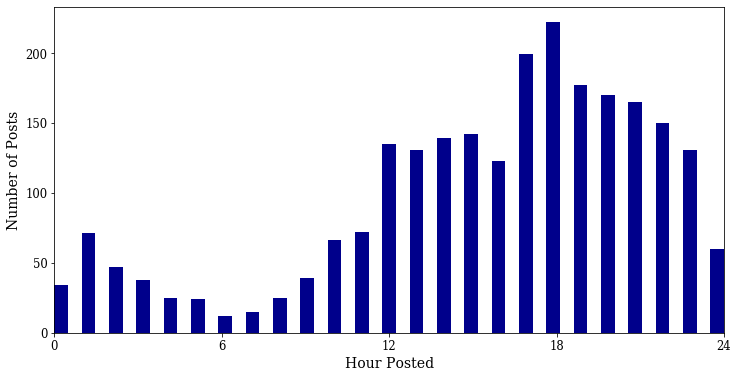

In [4]:
dataDict['hour'].plot.hist(bins=49, figsize=(12,6), color='darkblue', lw=0)

plt.ylabel('Number of Posts')
plt.xlabel('Hour Posted')
plt.xlim(0,24)
plt.xticks((0,6, 12, 18, 24))

plt.savefig(join(SAVE_PATH, 'postTime-' + igUser + '.png'))

## Pie plot of types of post

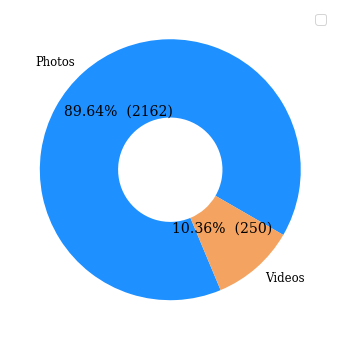

In [5]:
pieDf = pd.DataFrame()
pieDf['posts'] = Counter(dataDict['type']).values()
pieDf.index = Counter(dataDict['type']).keys()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

pieDf.plot.pie(y='posts', 
                figsize=(12, 6), 
                wedgeprops=dict(width=0.6), 
                startangle=-30, 
                autopct=make_autopct(pieDf['posts']), 
                labels=['Photos', 'Videos'], 
                colors=[ 'dodgerblue', 'sandybrown'])
plt.legend('')
plt.ylabel('')
plt.savefig(join(SAVE_PATH, 'typeOfPost-' + igUser + '.png'))

## Variation of Number of Likes with date

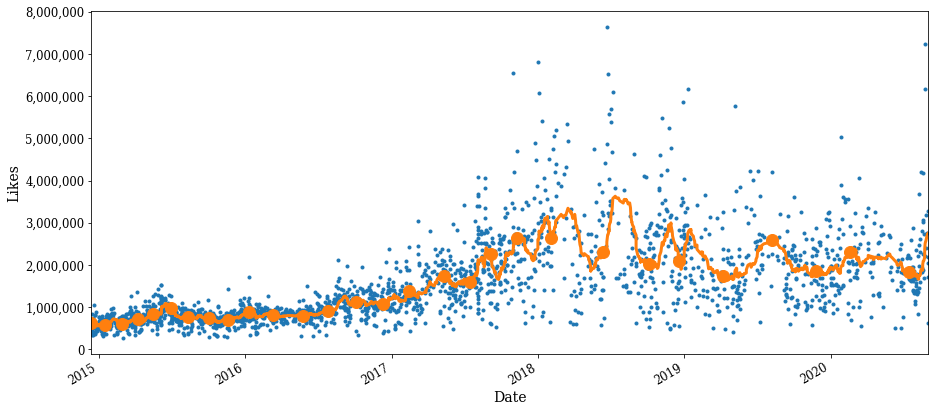

In [7]:
dataLikes = dataDict[['likes','date']][::-1].reset_index(drop=True)
dataLikes = dataLikes[dataLikes['likes'] != -1]
dataLikes.set_index('date',inplace=True)
dataLikes['MA'] = dataLikes['likes'].rolling(window=30).mean()

#plot data
fig, ax = plt.subplots(figsize=(15,7))
dataLikes.plot.line(y='likes', ax=ax, legend=None, style='.')

markevery = 80
dataLikes.plot.line(y='MA', ax=ax, legend=None, marker='o', markevery=markevery, linewidth=3, markersize=12)

plt.ylabel('Likes')
plt.xlabel('Date')

# Rewrite the y labels
y_labels = ax.get_yticks()

y_formatter = mp.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.yaxis.set_major_formatter(y_formatter)

#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
#set date limits
ax.set_xlim([dataLikes.index[markevery], dataLikes.index[-1]])
plt.savefig(join(SAVE_PATH, 'likesVersusDate-' + igUser + '.png'))

## Visual representation of most present alternative text in posted images

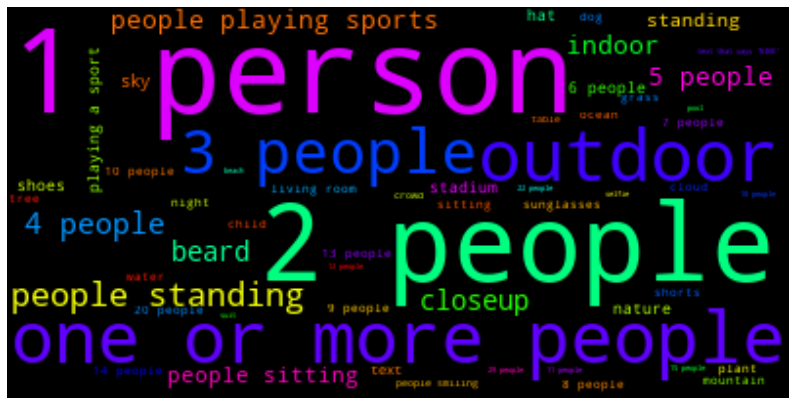

In [8]:
singleTagged = flatList(flatList(dataDict['image-may-contain']))

tagged = []
for item in singleTagged:
  if item:
    tagged.append(item)

imageMayContain = dict(Counter(tagged).most_common())

wordcloud = WordCloud(
    max_font_size=60,
    collocations=False, 
    colormap='gist_rainbow',
    background_color='black').generate_from_frequencies(imageMayContain)

fig, ax = plt.subplots(figsize=(14,8))

ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.savefig(join(SAVE_PATH, 'altImage-' + igUser + '.png'))


## Network graph of tagged in the same photo

### remove None from tagged list

In [9]:
taggedPeople = []
filterNone = lambda item: False if item == [None] else True

for line in dataDict['tagged-people'].values:
    filtered = list(filter(filterNone, line))
    if filtered:
        taggedPeople.append(filtered[0])

### Remove tagged people that were not tagged that much

In [10]:
minTagged = 6
taggedCount = dict(Counter(flatList(taggedPeople)).most_common())
taggedCountFiltered = {key: value for key, value in taggedCount.items() if int(value) > minTagged}
uniqueNames = list(taggedCountFiltered.keys())

### Generate Cooccurence graph

In [11]:
coOccurence = pd.DataFrame(0, index=uniqueNames, columns=uniqueNames)

for taggedWith in taggedPeople:
    for i, person1 in enumerate(taggedWith):
        for person2 in taggedWith[i+1:]:

            if not person1 in uniqueNames or not person2 in uniqueNames:
                continue

            else:
                coOccurence[person1][person2] += 1
                coOccurence[person2][person1] += 1

### Add weights to edges

In [12]:

edgeList = []
for index, row in coOccurence.iterrows():
    i = 0
    for col in row:
        weight = float(col)/464
        edgeList.append((index, coOccurence.columns[i], weight))
        i += 1

#Remove edge if 0.0
updatedEdgeList = [x for x in edgeList if not x[2] == 0.0]

In [13]:
fixedWidth = 0.01
updatedEdgeList2 = [[x[0], x[1], fixedWidth] for x in updatedEdgeList]

### Plot network graph

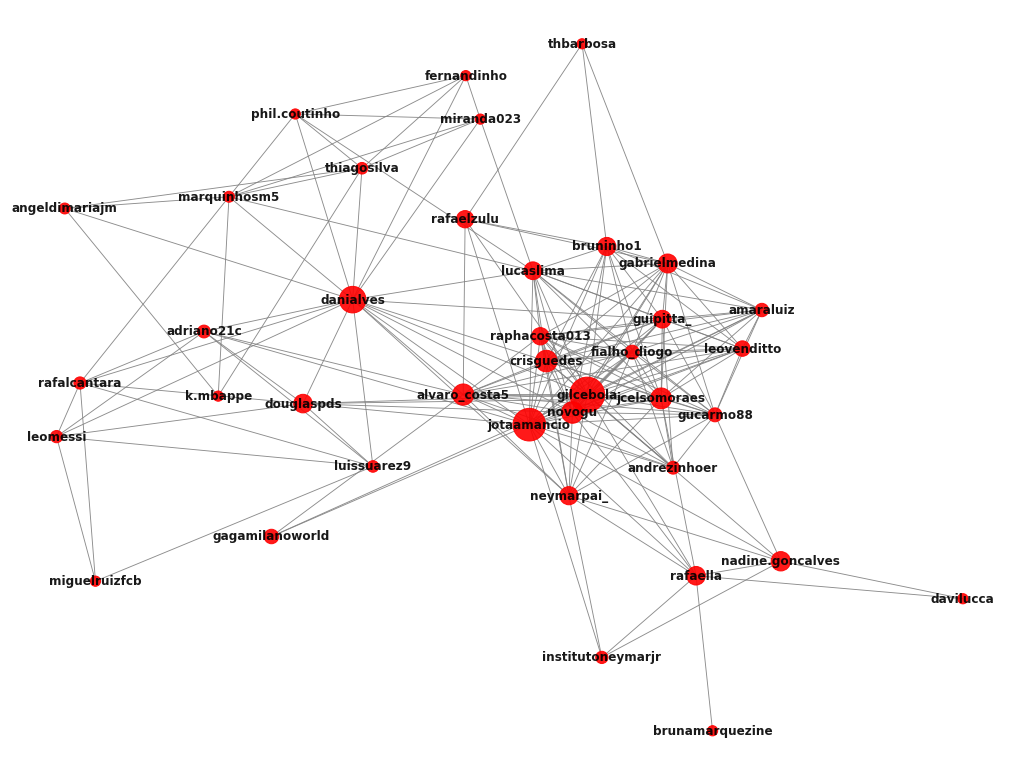

In [19]:
#set canvas size
plt.subplots(figsize=(18,14))

#networkx graph
G = nx.Graph()
G.add_weighted_edges_from(updatedEdgeList2)
            
#reorder edge list
test = nx.get_edge_attributes(G, 'weight')
updatedAgainEdges = []
for i in nx.edges(G):
    for x in test.keys():
        if i[0] == x[0] and i[1] == x[1]:
            updatedAgainEdges.append(test[x])

#drawing custimization
nodeScalar = 15
edgeScalar = 90
sizes = [x*nodeScalar for x in taggedCountFiltered.values()]
widths = [x*edgeScalar for x in updatedAgainEdges]

#draw the graph
pos = nx.spring_layout(G, iterations=50)

nx.draw(G, 
        pos, 
        with_labels=True, 
        font_size = 12, 
        font_weight = 'bold', 
        node_size = sizes, 
        width = widths, 
        node_color='red', 
        edge_color='gray', 
        alpha=0.9)

plt.savefig(join(SAVE_PATH, 'networkTaggedPeople-' + igUser + '.png'))